# Lab Practice: Online Learning

In [1]:
import pandas as pd

# Batch Libraries (Scikit-Learn)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Online Libraries (River)
from river import compose, tree, metrics, preprocessing

# Utilities
from lab1_utils import *

# Configuration
DATA_DIR = 'data/'

## Data loading and target preparation

In [2]:
# Load dataset
file_path = DATA_DIR + 'spy.us.txt'
df = pd.read_csv(file_path)

# Delete 'OpenInt' column (always 0 value)
if 'OpenInt' in df.columns:
    df = df.drop(columns=['OpenInt'])
    print("'OpenInt' column deleted successfully")

print(f"Initial number of rows: {len(df)}")

# Delete rows with missing values
df_cleaned = df.dropna()

print(f"Final columns: {df_cleaned.columns.tolist()}")
print(f"Final number of rows: {len(df_cleaned)}")

# Save cleaned dataset
df_cleaned.to_csv(DATA_DIR + 'spy_cleaned.csv', index=False)

'OpenInt' column deleted successfully
Initial number of rows: 3201
Final columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Final number of rows: 3201


In [3]:
# Load cleaned dataset
df = pd.read_csv(DATA_DIR + 'spy_cleaned.csv')

# Create the target: the 'High' 5 records ahead
# shift(-5) moves the values up by 5 positions.
# We are now predicting the value 5 days into the future to avoid naive correlation.
df['Target_High'] = df['High'].shift(-5)

# The last 5 rows do not have a "5th day future," so they become null (NaN)
df = df.dropna(subset=['Target_High'])

# Verify that Target_High is indeed the next day's High
print("\nFirst rows of the transformed dataset:")
df[['Date', 'High', 'Target_High']].head(21)


First rows of the transformed dataset:


,Date,High,Target_High
0,2005-02-25,106.00,107.01
1,2005-02-28,105.68,107.38
2,2005-03-01,105.87,107.15
3,2005-03-02,106.22,106.52
4,2005-03-03,106.20,105.85
5,2005-03-04,107.01,106.04
6,2005-03-07,107.38,105.56
7,2005-03-08,107.15,105.82
8,2005-03-09,106.52,104.44
9,2005-03-10,105.85,104.31


## Batch Learning

### Feature extraction and data splitting

In [4]:
# Data Splitting (Temporal Split - NO SHUFFLE): 70% training, 15% validation, and 15% test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

print(f"Total samples: {n}")

# Generate features and target for the entire dataset (train + val + test) to ensure we have the necessary history for feature generation
# This prevents the first 20 rows of the validation or test sets from becoming NaN due to insufficient historical data
X_full, y_full = get_batch_features_and_target(df)
print(f"Full shapes: X={X_full.shape}, y={y_full.shape}")

# Data splitting based on indices making sure that the cut respects the reduced dataframe after feature generation
X_train = X_full.loc[X_full.index < train_end]
y_train = y_full.loc[y_full.index < train_end]

X_val = X_full.loc[(X_full.index >= train_end) & (X_full.index < val_end)]
y_val = y_full.loc[(y_full.index >= train_end) & (y_full.index < val_end)]

X_test = X_full.loc[X_full.index >= val_end]
y_test = y_full.loc[y_full.index >= val_end]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Total samples: 3196
Full shapes: X=(3176, 8), y=(3176,)
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


In [5]:
X_train.head()

,Close,Return,Mean_return_5,Mean_return_20,Volatility_20,Open_Close_Diff,Volume,Volume_dev
20,102.19,0.001372,-0.002071,-0.001712,0.005964,-0.10,53885043,-15613298.30
21,101.51,-0.006654,-0.002686,-0.001709,0.005962,-0.54,83849903,14143833.75
22,102.96,0.014284,0.002193,-0.001252,0.006766,1.11,72199510,1613835.85
23,102.77,-0.001845,0.001667,-0.001320,0.006765,-0.20,74669192,4036712.75
24,102.30,-0.004573,0.000517,-0.001568,0.006789,-1.04,111800673,39142501.25


In [6]:
y_train.head()

20    102.67
21    103.12
22    103.62
23    103.89
24    103.85
Name: Target_High, dtype: float64

In [7]:
# Scale the data (standarization) to avoid inestability
scaler = StandardScaler()
# Obtain mean and std from the training data only to prevent data leakage
scaler.fit(X_train)

# Transfrom all sets with the obtained parameters from training set
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shapes after scaling:")
print(f"Train shapes: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test_scaled.shape}, y={y_test.shape}")

Shapes after scaling:
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


### Model 1: RandomForest

In [8]:
# Define and train model
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

Training Random Forest...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_predictions(model, X_scaled, y_real, df, set_name, model_name='Model'):
    y_pred = model.predict(X_scaled)
    mae = mean_absolute_error(y_real, y_pred)
    dates = pd.to_datetime(df.loc[y_real.index, 'Date'])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(dates, y_real.values, label='Real (Target High)', color='steelblue', linewidth=1.5)
    ax.plot(dates, y_pred,        label=f'{model_name} Prediction', color='tomato', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predicted ({set_name} Set)\nMAE: {mae:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae


In [10]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import numpy as np
# to test param
param_grid = {
    'max_depth':        [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features':     ['sqrt', 0.5, 1.0],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    param_grid,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_trainval, y_trainval)

print(f"Best param: {grid_search.best_params_}")
print(f"Best Val MAE:      {-grid_search.best_score_:.4f}")

Fitting 1 folds for each of 48 candidates, totalling 48 fits
Best param: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}
Best Val MAE:      19.4975


best one: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}



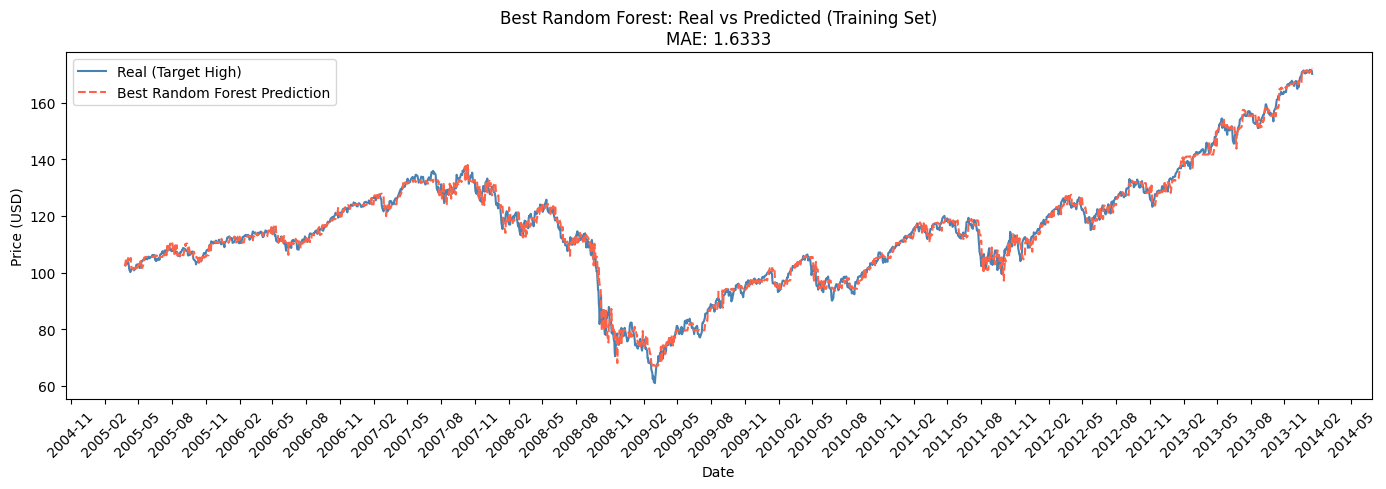

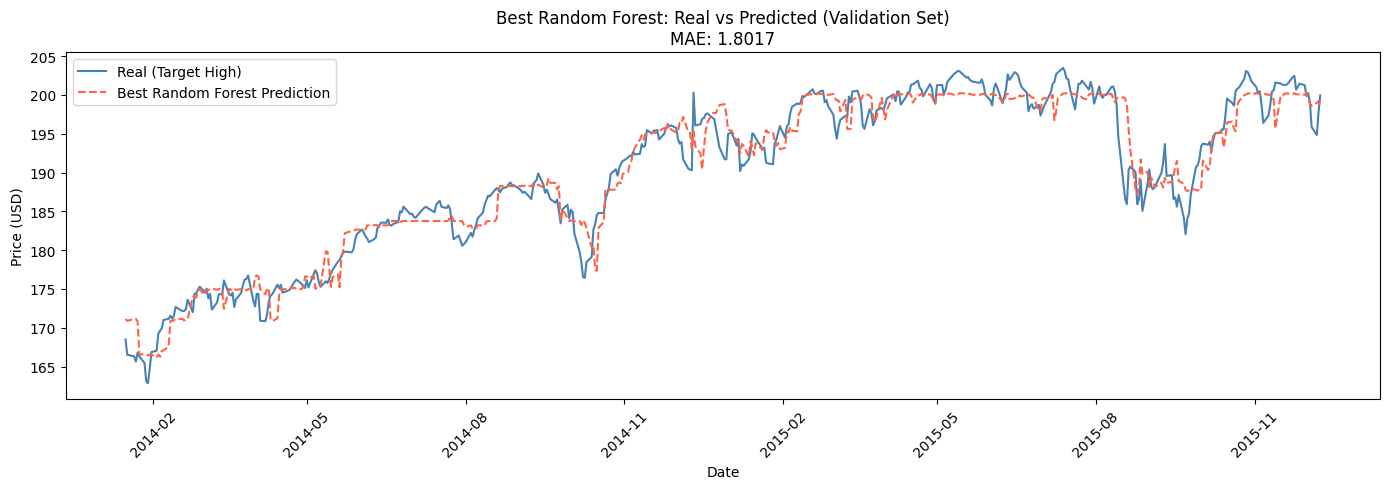

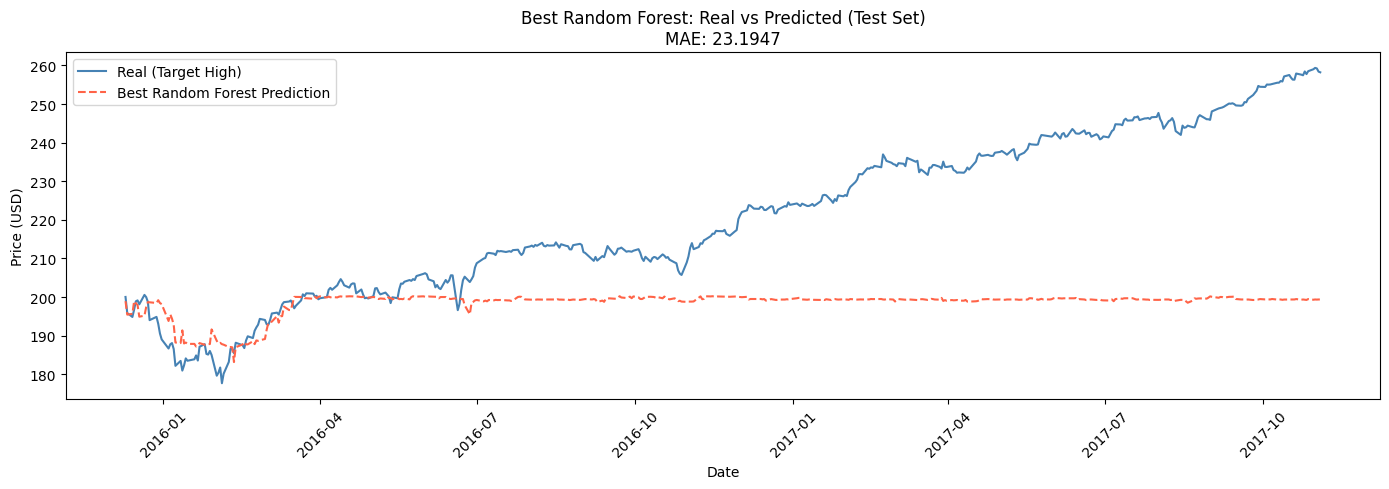

Best RF -> Train MAE: 1.6333
Best RF -> Val MAE:   1.8017
Best RF -> Test MAE:  23.1947


In [11]:
best_rf = grid_search.best_estimator_

print(f"best one: {grid_search.best_params_}\n")

mae_best_train = plot_predictions(best_rf, X_train_scaled, y_train, df, 'Training',   'Best Random Forest')
mae_best_val   = plot_predictions(best_rf, X_val_scaled,   y_val,   df, 'Validation', 'Best Random Forest')
mae_best_test  = plot_predictions(best_rf, X_test_scaled,  y_test,  df, 'Test',       'Best Random Forest')

print(f"Best RF -> Train MAE: {mae_best_train:.4f}")
print(f"Best RF -> Val MAE:   {mae_best_val:.4f}")
print(f"Best RF -> Test MAE:  {mae_best_test:.4f}")

In [12]:
#lo que pasa es el top de validation. no supera la el maximo de validation. 

### Model 2: GradientBoosting

In [13]:
# Define and train model
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

Training Gradient Boosting...


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [14]:
# Evaluation GBM
mae_gb_val = mean_absolute_error(y_val, gb_model.predict(X_val_scaled))
print(f"Gradient Boost -> Val MAE: {mae_gb_val:.4f}")

Gradient Boost -> Val MAE: 19.7642


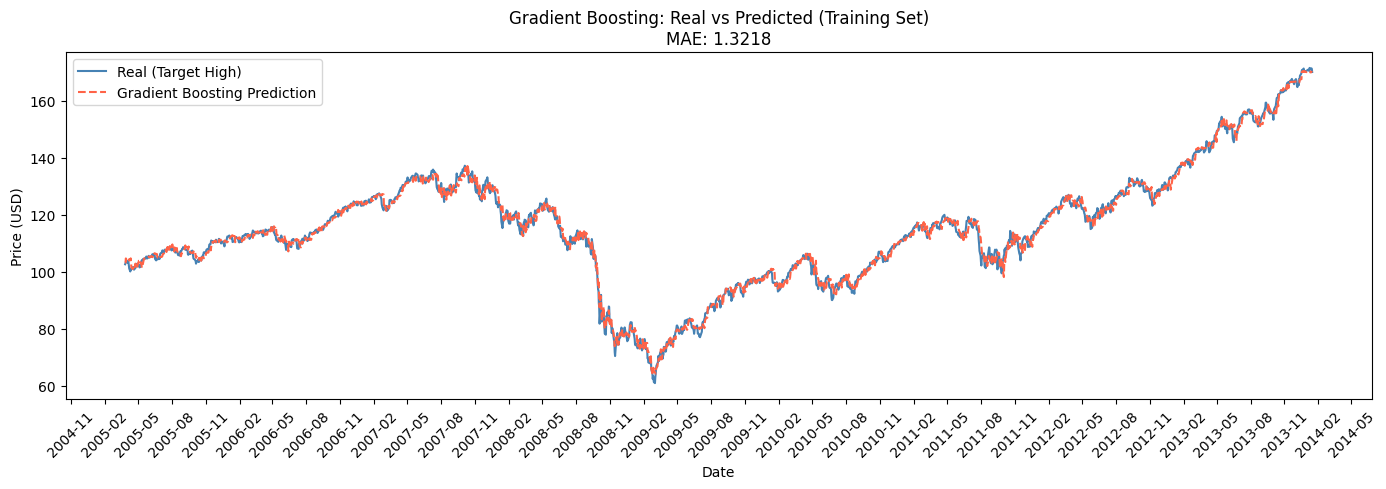

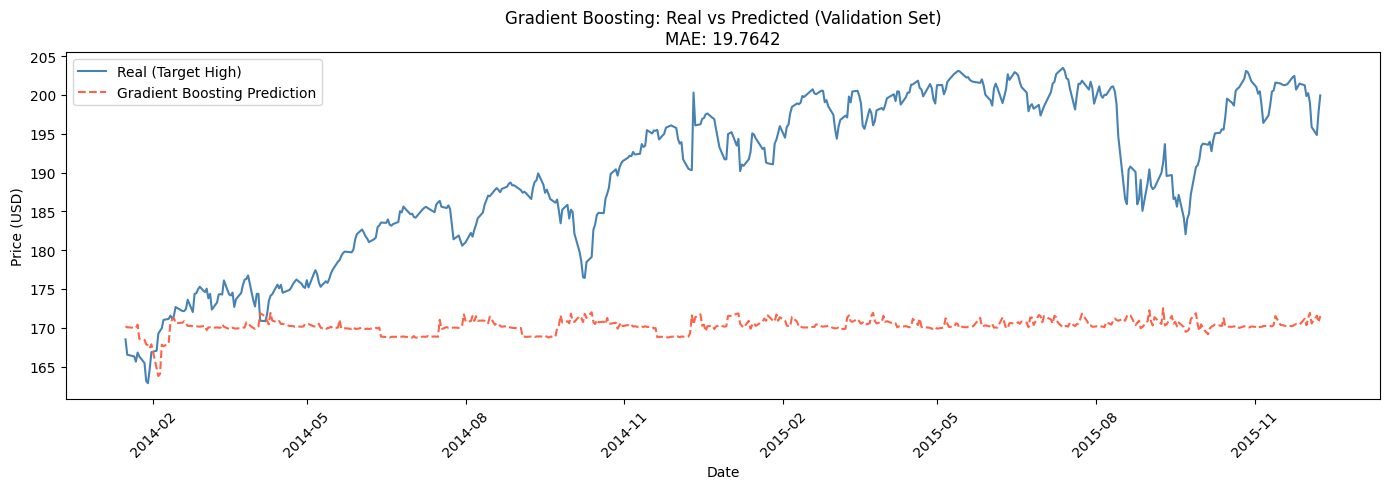

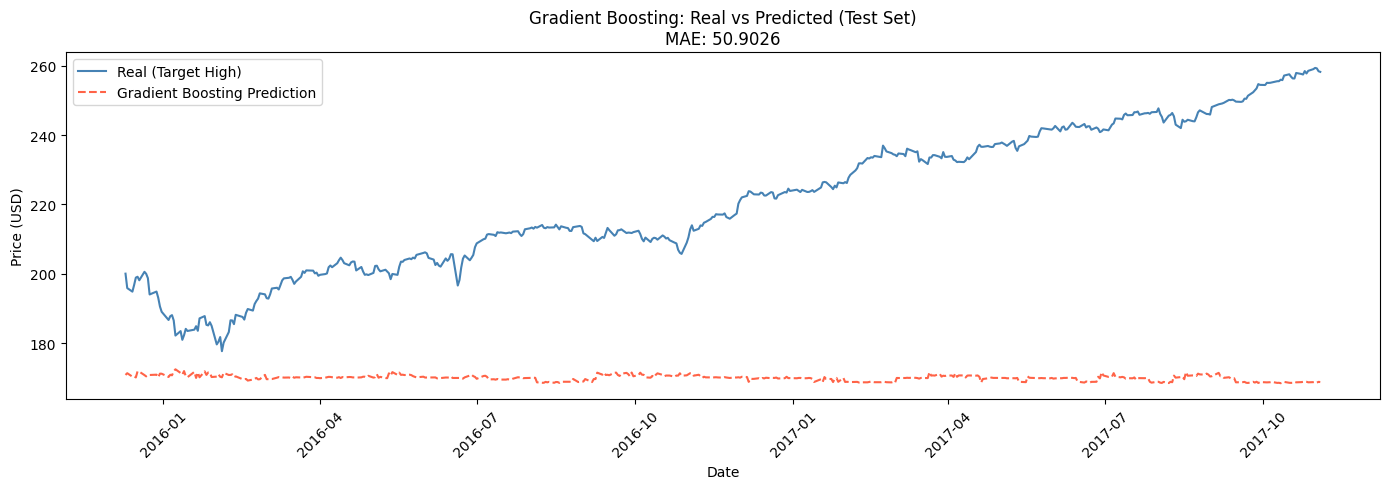

Gradient Boosting -> Train MAE: 1.3218
Gradient Boosting -> Val MAE:   19.7642
Gradient Boosting -> Test MAE:  50.9026


In [15]:
mae_gb_train = plot_predictions(gb_model, X_train_scaled, y_train, df, 'Training',   'Gradient Boosting')
mae_gb_val   = plot_predictions(gb_model, X_val_scaled,   y_val,   df, 'Validation', 'Gradient Boosting')
mae_gb_test  = plot_predictions(gb_model, X_test_scaled,  y_test,  df, 'Test',       'Gradient Boosting')

print(f"Gradient Boosting -> Train MAE: {mae_gb_train:.4f}")
print(f"Gradient Boosting -> Val MAE:   {mae_gb_val:.4f}")
print(f"Gradient Boosting -> Test MAE:  {mae_gb_test:.4f}")

In [16]:
param_grid_gb = {
    'n_estimators':     [100, 200],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search_gb.fit(X_trainval, y_trainval)

print(f"Best params: {grid_search_gb.best_params_}")
print(f"Best Val MAE: {-grid_search_gb.best_score_:.4f}")

Fitting 1 folds for each of 54 candidates, totalling 54 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Val MAE: 19.2517


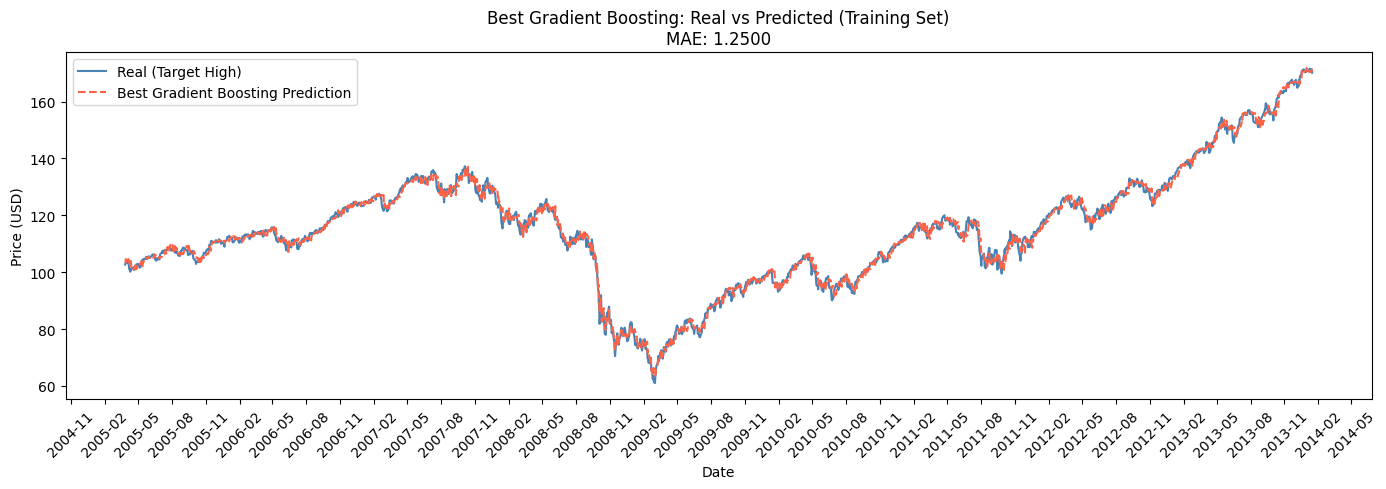

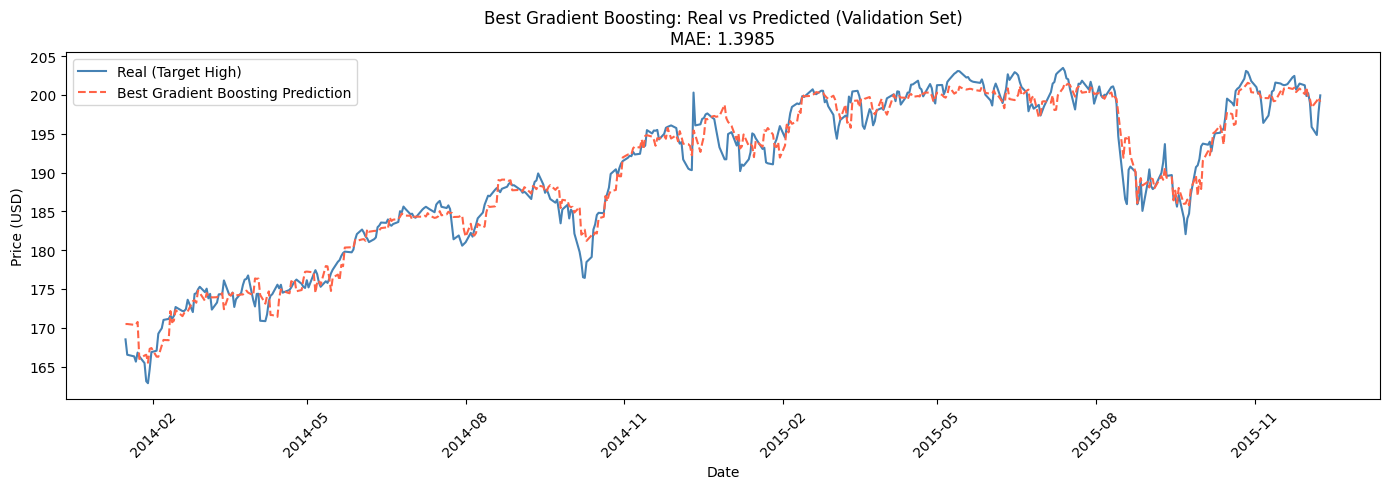

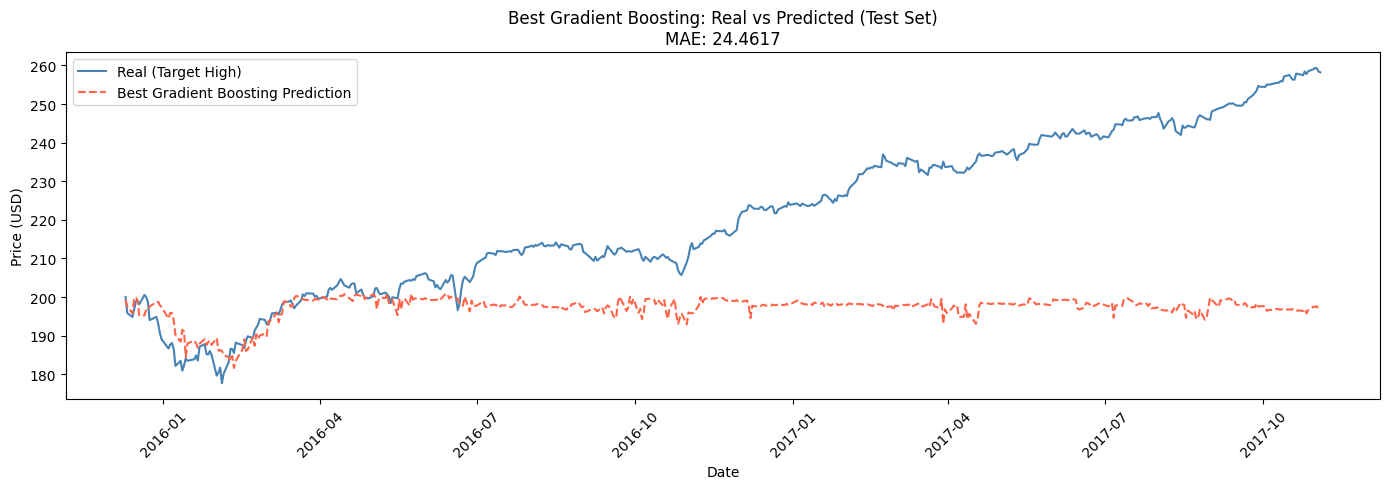

Best GBM -> Train MAE: 1.2500
Best GBM -> Val MAE:   1.3985
Best GBM -> Test MAE:  24.4617


In [17]:
best_gb = grid_search_gb.best_estimator_

mae_best_gb_train = plot_predictions(best_gb, X_train_scaled, y_train, df, 'Training',   'Best Gradient Boosting')
mae_best_gb_val   = plot_predictions(best_gb, X_val_scaled,   y_val,   df, 'Validation', 'Best Gradient Boosting')
mae_best_gb_test  = plot_predictions(best_gb, X_test_scaled,  y_test,  df, 'Test',       'Best Gradient Boosting')

print(f"Best GBM -> Train MAE: {mae_best_gb_train:.4f}")
print(f"Best GBM -> Val MAE:   {mae_best_gb_val:.4f}")
print(f"Best GBM -> Test MAE:  {mae_best_gb_test:.4f}")

### Model 3: CNN


### Model 3 (Revised): CNN+LSTM Hybrid

**Why CNN+LSTM for financial time series?**

- **1D Conv layers** act as learned band-pass filters: they extract local temporal patterns (3-5 day momentum, volume spikes) without requiring the LSTM to simultaneously handle short-range and long-range dependencies.
- **LSTM** then models long-range dependencies between the higher-level representations produced by the CNN — an easier optimisation landscape.
- **BatchNormalization** after Conv1D regularises intermediate activations, important given the small training set (~2,200 samples) and regime changes (2008 crash, 2020 COVID).
- **ReduceLROnPlateau** (patience=7) reduces the learning rate before **EarlyStopping** (patience=15) halts training — the model benefits from at least one LR reduction before stopping.
- **Random Search** (25 configs sampled from ~7,776 combinations) covers a much wider hyperparameter space than the exhaustive 32-config LSTM grid search.


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as _mae
import pandas as pd

def build_cnn_lstm_model(seq_len, n_features, conv_filters, kernel_size,
                          n_conv_layers, lstm_units, n_lstm_layers,
                          dropout, dense_units, learning_rate,
                          use_batch_norm=True):
    """
    CNN+LSTM hybrid for time-series regression.

    Architecture:
        Input  (batch, seq_len, n_features)
        -> [Conv1D(relu) -> BatchNorm?] x n_conv_layers   # local pattern extraction
        -> MaxPooling1D(pool_size=2)                       # temporal downsampling
        -> [LSTM -> Dropout] x n_lstm_layers               # long-range dependencies
        -> Dense(dense_units, relu)
        -> Dense(1)                                         # regression output

    Key design choices:
    - padding='same' on Conv1D keeps the temporal dimension intact (no kernel_size crash)
    - clipnorm=1.0 in Adam: gradient clipping for stability on financial data
    - BatchNorm after Conv1D: regularises + accelerates convergence
    - Functional API: cleaner than Sequential for variable layer counts
    """
    inputs = Input(shape=(seq_len, n_features))
    x = inputs

    # Convolutional blocks
    for _ in range(n_conv_layers):
        x = Conv1D(filters=conv_filters, kernel_size=kernel_size,
                   activation='relu', padding='same')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)

    # Single pooling step after all conv blocks (halves temporal dimension)
    if seq_len >= 4:
        x = MaxPooling1D(pool_size=2)(x)

    # LSTM blocks
    for i in range(n_lstm_layers):
        return_sequences = (i < n_lstm_layers - 1)
        x = LSTM(units=lstm_units, return_sequences=return_sequences)(x)
        x = Dropout(dropout)(x)

    # Regression head
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mae'
    )
    return model


In [22]:
# ramdom seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Hyperparameter space (wider than LSTM grid)
param_space_cnn_lstm = {
    'seq_len'      : [20, 30, 40],
    'conv_filters' : [32, 64, 128],
    'kernel_size'  : [3, 5],
    'n_conv_layers': [1, 2],
    'lstm_units'   : [32, 64, 128],
    'n_lstm_layers': [1, 2],
    'dropout'      : [0.1, 0.2, 0.3],
    'dense_units'  : [32, 64],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size'   : [32, 64],
}


N_RANDOM_CONFIGS = 25

def sample_random_config(space):
    return {k: random.choice(v) for k, v in space.items()}

sampled_configs = []
seen = set()
attempts = 0
while len(sampled_configs) < N_RANDOM_CONFIGS and attempts < 2000:
    cfg = sample_random_config(param_space_cnn_lstm)
    key = tuple(sorted(cfg.items()))
    if key not in seen:
        seen.add(key)
        sampled_configs.append(cfg)
    attempts += 1

print(f"Configurations sampled: {len(sampled_configs)}")

# Callback factory 
def make_callbacks():
    """
    EarlyStopping (patience=15) fires AFTER ReduceLROnPlateau (patience=7).
    This ensures the LR is reduced at least once before training stops.
    """
    return [
        EarlyStopping(monitor='val_loss', patience=15,
                      restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                          patience=7, min_lr=1e-6, verbose=0),
    ]

# Random search loop
n_features_cnn = X_tr.shape[1]   
n_train_cnn    = len(X_tr)      

best_val_mae_cnn = np.inf
best_params_cnn  = None
best_model_cnn   = None
best_seq_len_cnn = None
grid_results_cnn = []

for idx, params in enumerate(sampled_configs):
    seq_len    = params['seq_len']
    batch_size = params['batch_size']

    # Build sequences using existing make_sequences function (no changes needed)
    X_seq_tv_rs, y_seq_tv_rs = make_sequences(
        np.concatenate([X_tr, X_vl]),
        np.concatenate([y_tr, y_vl]),
        seq_len
    )
    split_rs = n_train_cnn - seq_len

    X_seq_train_rs = X_seq_tv_rs[:split_rs]
    y_seq_train_rs = y_seq_tv_rs[:split_rs]
    X_seq_val_rs   = X_seq_tv_rs[split_rs:]
    y_seq_val_rs   = y_seq_tv_rs[split_rs:]

    tf.keras.backend.clear_session()

    model_rs = build_cnn_lstm_model(
        seq_len       = seq_len,
        n_features    = n_features_cnn,
        conv_filters  = params['conv_filters'],
        kernel_size   = params['kernel_size'],
        n_conv_layers = params['n_conv_layers'],
        lstm_units    = params['lstm_units'],
        n_lstm_layers = params['n_lstm_layers'],
        dropout       = params['dropout'],
        dense_units   = params['dense_units'],
        learning_rate = params['learning_rate'],
    )

    model_rs.fit(
        X_seq_train_rs, y_seq_train_rs,
        validation_data = (X_seq_val_rs, y_seq_val_rs),
        epochs          = 100,
        batch_size      = batch_size,
        callbacks       = make_callbacks(),
        verbose         = 0,
    )

    y_pred_val_rs = model_rs.predict(X_seq_val_rs, verbose=0).flatten()
    val_mae_rs    = _mae(y_seq_val_rs, y_pred_val_rs)
    grid_results_cnn.append({**params, 'val_mae': val_mae_rs})

    if val_mae_rs < best_val_mae_cnn:
        best_val_mae_cnn = val_mae_rs
        best_params_cnn  = params.copy()
        best_model_cnn   = model_rs
        best_seq_len_cnn = seq_len

    print(f"[{idx+1:2d}/{N_RANDOM_CONFIGS}] {params}  ->  Val MAE: {val_mae_rs:.4f}")

print(f"\n>>> Best CNN+LSTM config : {best_params_cnn}")
print(f">>> Best CNN+LSTM Val MAE: {best_val_mae_cnn:.4f}")


df_cnn_results = pd.DataFrame(grid_results_cnn).sort_values('val_mae')
print("\nAll configurations (sorted by Val MAE):")
print(df_cnn_results.to_string(index=False))


Configurations sampled: 25
[ 1/25] {'seq_len': 40, 'conv_filters': 32, 'kernel_size': 3, 'n_conv_layers': 2, 'lstm_units': 32, 'n_lstm_layers': 1, 'dropout': 0.1, 'dense_units': 32, 'learning_rate': 0.0001, 'batch_size': 32}  ->  Val MAE: 41.6844
[ 2/25] {'seq_len': 40, 'conv_filters': 64, 'kernel_size': 3, 'n_conv_layers': 1, 'lstm_units': 32, 'n_lstm_layers': 1, 'dropout': 0.1, 'dense_units': 32, 'learning_rate': 0.0001, 'batch_size': 32}  ->  Val MAE: 40.9529
[ 3/25] {'seq_len': 40, 'conv_filters': 128, 'kernel_size': 5, 'n_conv_layers': 1, 'lstm_units': 64, 'n_lstm_layers': 2, 'dropout': 0.1, 'dense_units': 32, 'learning_rate': 0.0001, 'batch_size': 64}  ->  Val MAE: 41.8692
[ 4/25] {'seq_len': 30, 'conv_filters': 64, 'kernel_size': 3, 'n_conv_layers': 1, 'lstm_units': 64, 'n_lstm_layers': 1, 'dropout': 0.1, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 64}  ->  Val MAE: 25.5339
[ 5/25] {'seq_len': 30, 'conv_filters': 128, 'kernel_size': 5, 'n_conv_layers': 1, 'lstm_unit

CNN+LSTM  Train MAE: 1.6567
CNN+LSTM  Val   MAE: 19.5004
CNN+LSTM  Test  MAE: 50.0233


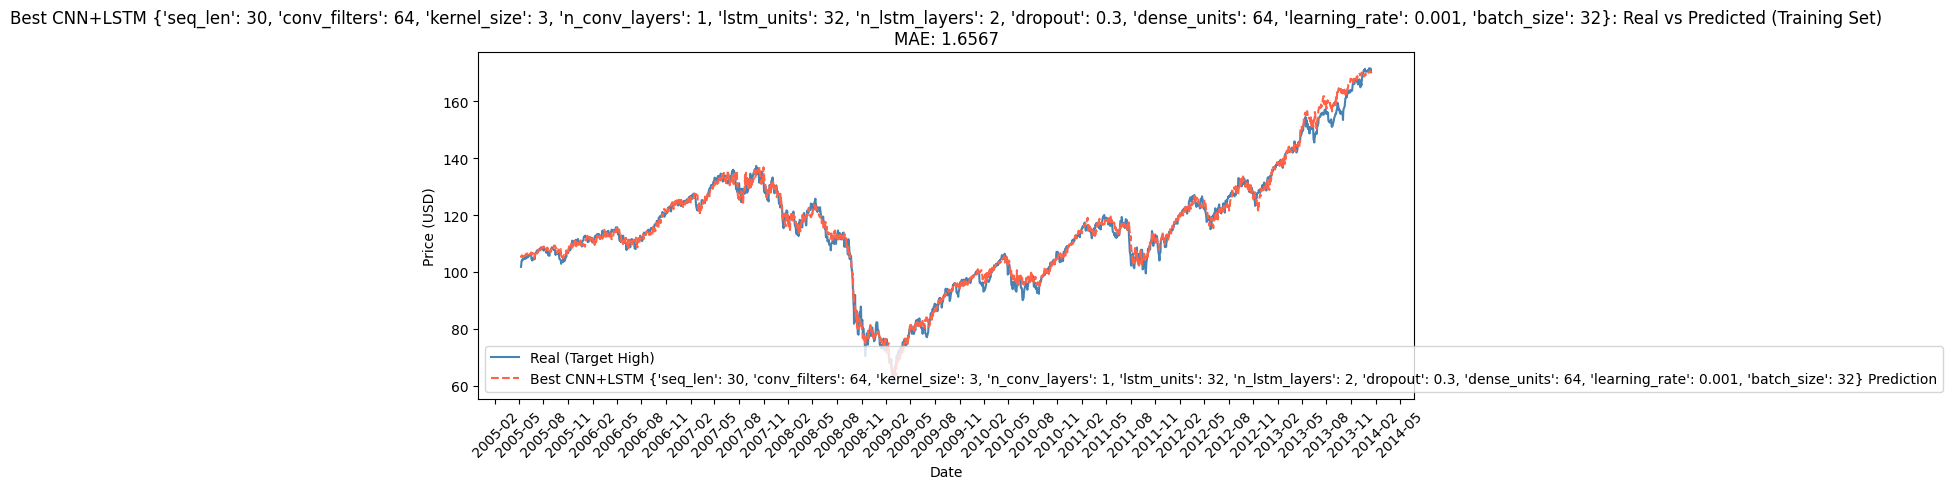

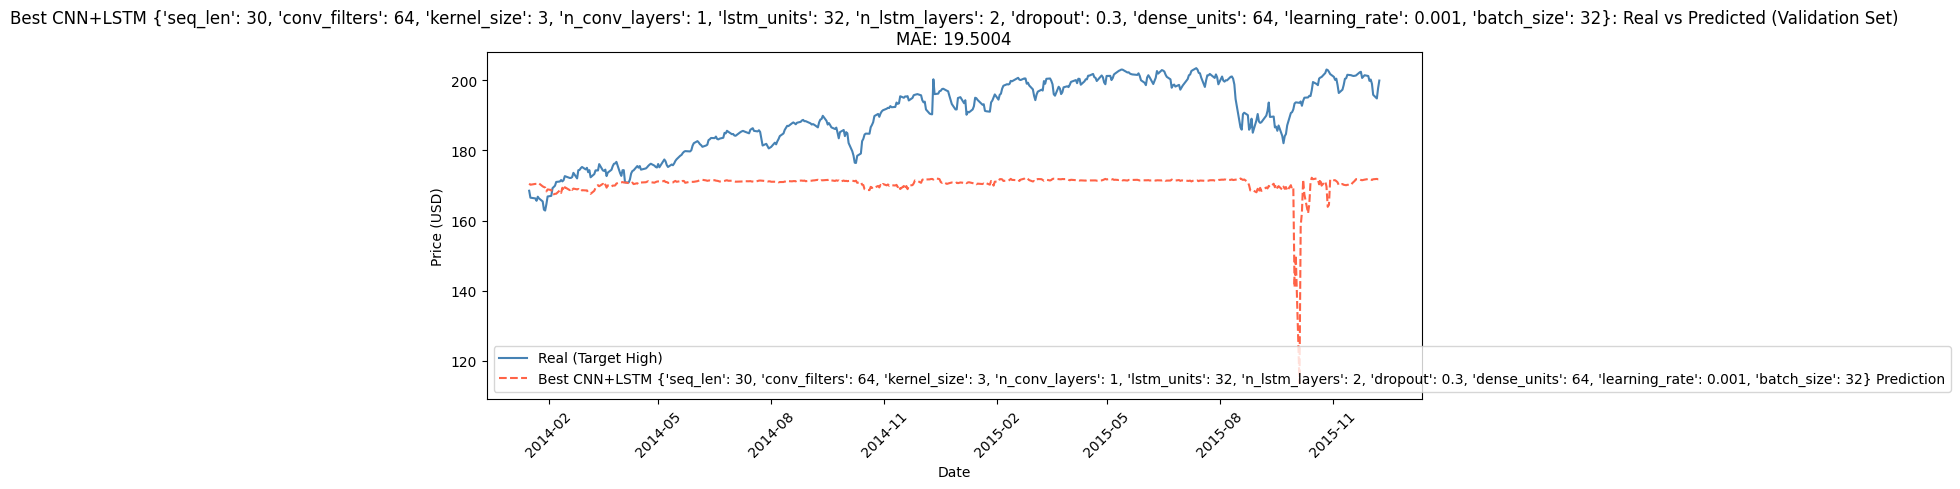

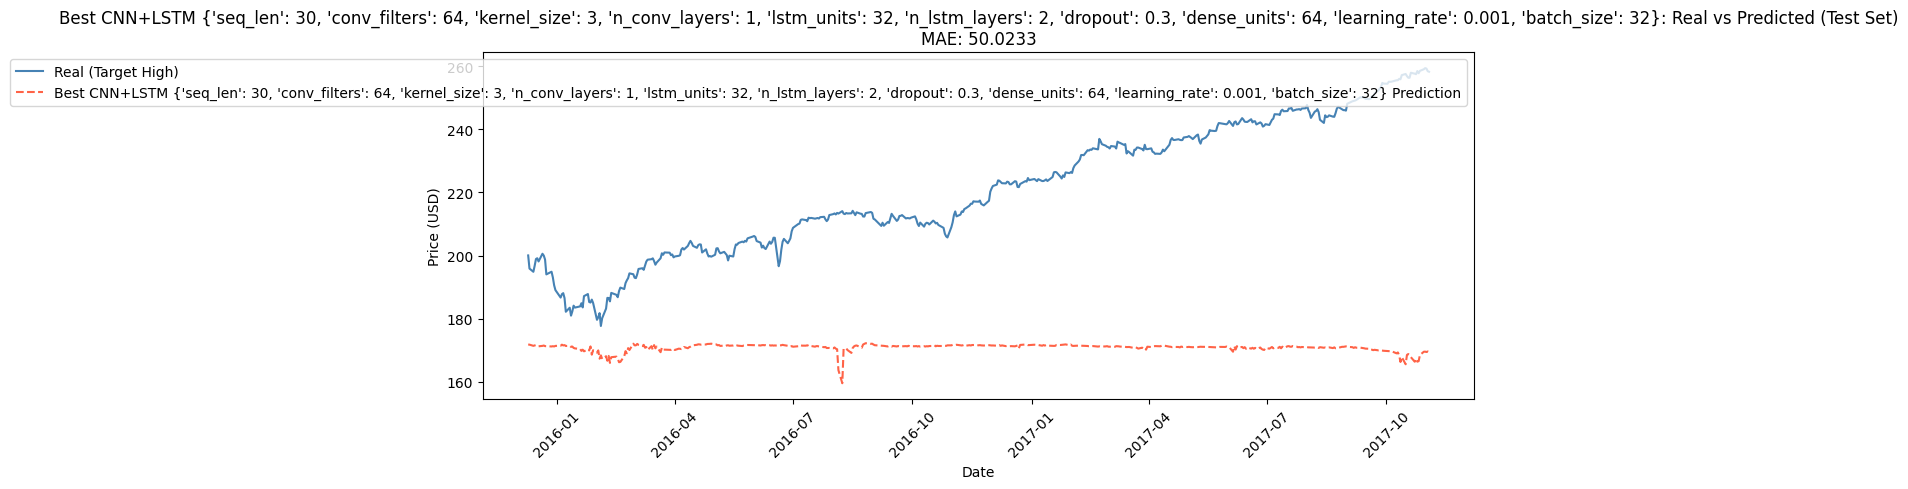


Best CNN+LSTM -> Train MAE: 1.6567
Best CNN+LSTM -> Val   MAE: 19.5004
Best CNN+LSTM -> Test  MAE: 50.0233


In [23]:
# ── Final evaluation and plots for the best CNN+LSTM model ───────────────
seq_len = best_seq_len_cnn
n_train = len(X_tr)

# ── Test sequences (val tail used as context) ─────────────────────────────
X_vt_cnn = np.concatenate([X_vl, X_te])
y_vt_cnn = np.concatenate([y_vl, y_te])
X_seq_vt_cnn, y_seq_vt_cnn = make_sequences(X_vt_cnn, y_vt_cnn, seq_len)
split_vt_cnn = len(X_vl) - seq_len
X_seq_test_cnn = X_seq_vt_cnn[split_vt_cnn:]
y_seq_test_cnn = y_seq_vt_cnn[split_vt_cnn:]

# ── Train / val sequences (for plots) ─────────────────────────────────────
X_tv_cnn = np.concatenate([X_tr, X_vl])
y_tv_cnn = np.concatenate([y_tr, y_vl])
X_seq_tv_cnn, y_seq_tv_cnn = make_sequences(X_tv_cnn, y_tv_cnn, seq_len)
split_tv_cnn     = n_train - seq_len
X_seq_train_best = X_seq_tv_cnn[:split_tv_cnn]
y_seq_train_best = y_seq_tv_cnn[:split_tv_cnn]
X_seq_val_best   = X_seq_tv_cnn[split_tv_cnn:]
y_seq_val_best   = y_seq_tv_cnn[split_tv_cnn:]

# ── Predictions ───────────────────────────────────────────────────────────
y_pred_train_cnn = best_model_cnn.predict(X_seq_train_best, verbose=0).flatten()
y_pred_val_cnn   = best_model_cnn.predict(X_seq_val_best,   verbose=0).flatten()
y_pred_test_cnn  = best_model_cnn.predict(X_seq_test_cnn,   verbose=0).flatten()

# ── MAE ───────────────────────────────────────────────────────────────────
train_mae_cnn = mean_absolute_error(y_seq_train_best, y_pred_train_cnn)
val_mae_cnn   = best_val_mae_cnn
test_mae_cnn  = mean_absolute_error(y_seq_test_cnn,   y_pred_test_cnn)

print(f"CNN+LSTM  Train MAE: {train_mae_cnn:.4f}")
print(f"CNN+LSTM  Val   MAE: {val_mae_cnn:.4f}")
print(f"CNN+LSTM  Test  MAE: {test_mae_cnn:.4f}")

# ── Date alignment (same as LSTM) ─────────────────────────────────────────
train_date_index_cnn = X_train.index[seq_len:]   # skip first seq_len rows
val_date_index_cnn   = X_val.index
test_date_index_cnn  = X_test.index

# ── Plots (reuse plot_predictions_lstm defined in previous cell) ───────────
label_cnn = f'Best CNN+LSTM {best_params_cnn}'

mae_cnn_train = plot_predictions_lstm(y_seq_train_best, y_pred_train_cnn,
                                       train_date_index_cnn, 'Training', label_cnn)
mae_cnn_val   = plot_predictions_lstm(y_seq_val_best,   y_pred_val_cnn,
                                       val_date_index_cnn,   'Validation', label_cnn)
mae_cnn_test  = plot_predictions_lstm(y_seq_test_cnn,   y_pred_test_cnn,
                                       test_date_index_cnn,  'Test', label_cnn)

print(f"\nBest CNN+LSTM -> Train MAE: {mae_cnn_train:.4f}")
print(f"Best CNN+LSTM -> Val   MAE: {mae_cnn_val:.4f}")
print(f"Best CNN+LSTM -> Test  MAE: {mae_cnn_test:.4f}")


## Online Learning

In [33]:
# Create Pipeline: Feature Extraction -> Model
# We use HoeffdingAdaptiveTreeRegressor
river_model = compose.Pipeline(
    OnlineSPYFeatures(),   # Custom transformer to extract features from the raw data stream
    preprocessing.StandardScaler(),  # Scales the data (standarization) to avoid inestability
    tree.HoeffdingAdaptiveTreeRegressor(
        grace_period=50,       # How often to check for splits
        model_selector_decay=0.9
    )
)

# Metric for Validation
metric_val  = metrics.MAE()
metric_test = metrics.MAE()

In [34]:
# We iterate through the entire dataset sequentially
print("Processing stream row by row...")
records_val  = []
records_test = []
for i, (index, row) in enumerate(df.iterrows()):
    
    # Prepare input (x) and target (y)
    x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
    y = row['Target_High']
    
    # 1. PREDICT (Test-then-Train approach)
    # We make a prediction before the model learns from this specific example
    y_pred = river_model.predict_one(x)   # predict_one takes the x, transforms it with OnlineSPYFeatures and StandardScaler, and predicts with the model
    
    # 2. UPDATE METRICS
    # We only update the metric if we are currently in the Validation segment (would be equivalent for test)
    if index in X_val.index:
        metric_val.update(y, y_pred)
        records_val.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})

    if index in X_test.index:
        metric_test.update(y, y_pred)
        records_test.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
    # 3. LEARN
    # The model updates its internal state with the new truth
    river_model.learn_one(x, y)

Processing stream row by row...


In [35]:
print(f"Online HoeffdingAdaptiveTreeRegressor -> Val MAE: {metric_val.get():.4f}")
print(f"Online HoeffdingAdaptiveTreeRegressor -> Val MAE: {metric_test.get():.4f}")

Online HoeffdingAdaptiveTreeRegressor -> Val MAE: 4.0260
Online HoeffdingAdaptiveTreeRegressor -> Val MAE: 3.1520


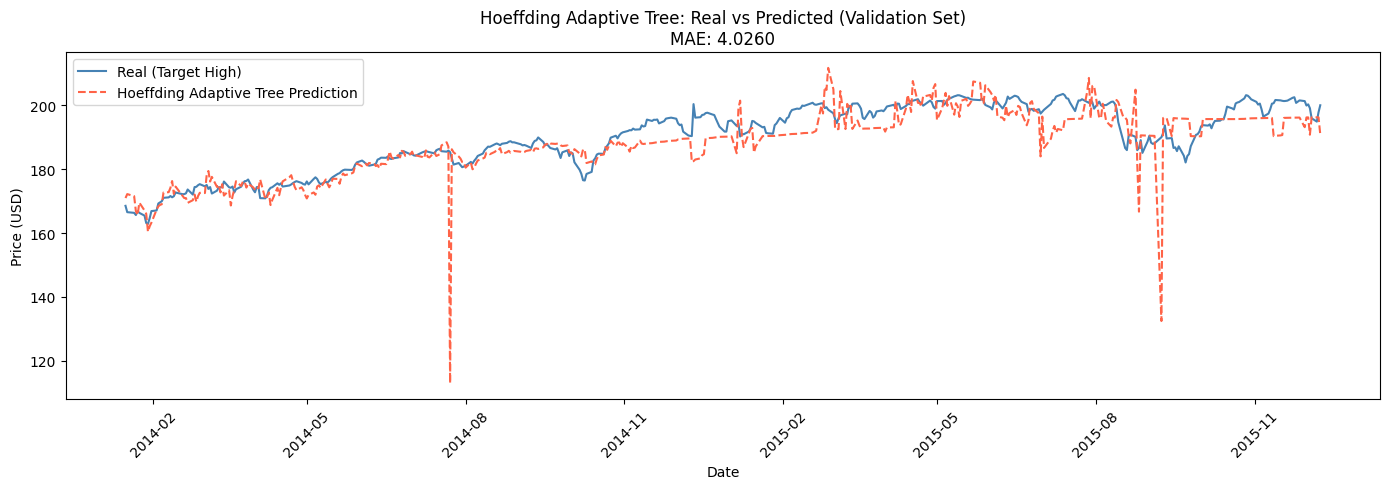

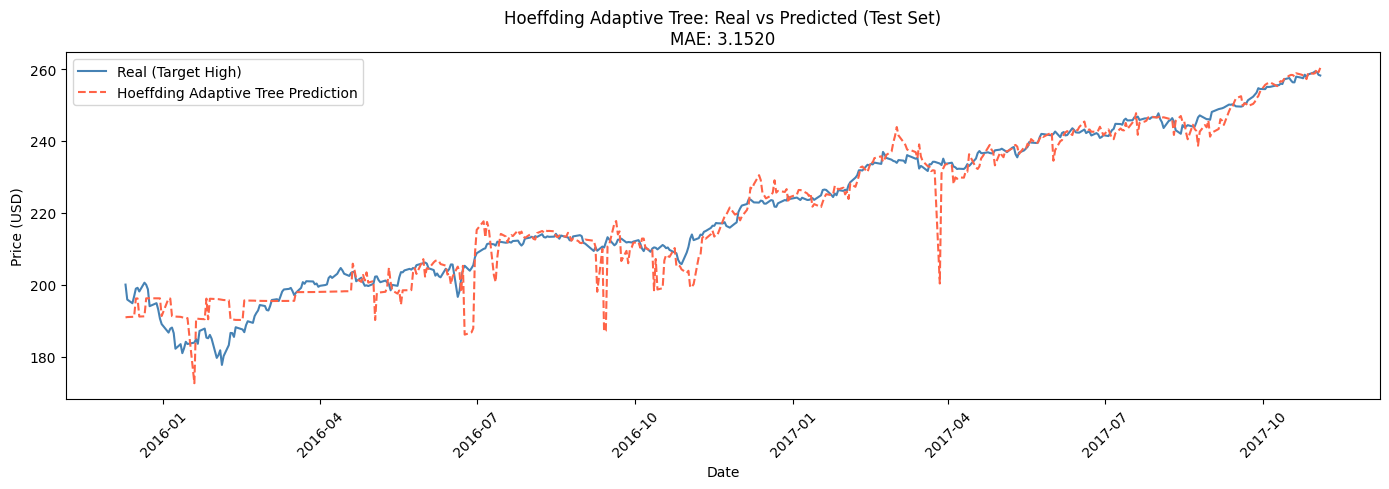

In [36]:
def plot_predictions_online(records, set_name, model_name='Online Model'):
    df_plot = pd.DataFrame(records)
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    mae = mean_absolute_error(df_plot['y_real'], df_plot['y_pred'])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df_plot['date'], df_plot['y_real'], label='Real (Target High)', color='steelblue', linewidth=1.5)
    ax.plot(df_plot['date'], df_plot['y_pred'], label=f'{model_name} Prediction', color='tomato', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predicted ({set_name} Set)\nMAE: {mae:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae


mae_online_val  = plot_predictions_online(records_val,  'Validation', 'Hoeffding Adaptive Tree')
mae_online_test = plot_predictions_online(records_test, 'Test',       'Hoeffding Adaptive Tree')
